# Exploratory data analysis of the Cervical cancer (Risk factors) Data set

In [1]:
import numpy as np
import pandas as pd
import altair as alt
from sklearn.model_selection import train_test_split

alt.data_transformers.enable('data_server')
alt.renderers.enable('mimetype')

RendererRegistry.enable('mimetype')

# Summary of the data set
---
The data set was collected at 'Hospital Universitario de Caracas' in Caracas, Venezuela. The data set comprises demographic information, habits, and historic medical records of 858 patients. Several patients decided not to answer some of the questions because of privacy concerns (missing values). This data set was sourced from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php) and can be found [here](https://archive.ics.uci.edu/ml/datasets/Cervical+cancer+%28Risk+Factors%29#).

The data set was used in Kelwin Fernandes, Jaime S. Cardoso, and Jessica Fernandes. 'Transfer Learning with Partial Observability Applied to Cervical Cancer Screening.' Iberian Conference on Pattern Recognition and Image Analysis. Springer International Publishing, 2017, available [here](https://www.semanticscholar.org/paper/Transfer-Learning-with-Partial-Observability-to-Fernandes-Cardoso/1c02438ba4dfa775399ba414508e9cd335b69012).

The data set has 4 different target variables each having a value of 0(tested negative for that specific medical test) or 1(tested positive for that specific medical test). For the purpose of this project, these binary class variables will be combined into a single binary target variable which will be 1(True) if any medical test is positive and 0(False) if no test was positive.


In [2]:
# load dataset into pandas dataframe
cervical_raw = pd.read_csv('data/risk_factors_cervical_cancer.csv')

# create target variable 'risk'
risk = []
for row in range(len(cervical_raw)):
    risk.append(
        cervical_raw.loc[cervical_raw.index[row], 'Hinselmann'] or
        cervical_raw.loc[cervical_raw.index[row], 'Schiller'] or
        cervical_raw.loc[cervical_raw.index[row], 'Citology'] or
        cervical_raw.loc[cervical_raw.index[row], 'Biopsy']         
    )
cervical_modified = cervical_raw.copy()
cervical_modified['risk'] = risk

# drop the previous target variables
cervical_modified = cervical_modified.drop(columns=['Hinselmann', 'Schiller', 'Citology', 'Biopsy'])

# create dataframe with counts of each class
class_counts = pd.DataFrame(cervical_modified['risk'].value_counts()).rename(index={0:'No risk of cervical cancer',
                                                                                    1:'Risk of cervical cancer'},
                                                                             columns={'risk':'Target'})
# set caption for Table 1                                                                             
class_counts.style.set_caption('Table 1. Counts of observation for each class')

,Target
No risk of cervical cancer,756
Risk of cervical cancer,102


# Split data set into training and test splits
---

before splitting the dataset, we replace all occurences of '?' in the data with `np.nan` so that it is easier to work with the missing values. We also change the data types of columns to match the data stored in them.

In [3]:
# replace the ? values with NaN
cervical_clean = cervical_modified.replace('?', np.nan)

# convert columns to relevant data types
for col_name in cervical_clean.columns:
    if cervical_clean[col_name].dtype == 'object':
        cervical_clean[col_name] = cervical_clean[col_name].astype(float)

We now split our data so that 80% of the examples are in the training set while 20% are in the test set.

In [4]:
# split data into training and test sets
train_df, test_df = train_test_split(cervical_clean, test_size=0.2, random_state=123)

In [5]:
# create dataframe with counts of each class and for both train and test set
train_class_counts = pd.DataFrame(train_df['risk'].value_counts())
test_class_counts = pd.DataFrame(test_df['risk'].value_counts())

train_test_class_counts = pd.concat([train_class_counts, test_class_counts], axis=1).rename(
    index={0:'No risk of cervical cancer',
           1:'Risk of cervical cancer'}
)
train_test_class_counts.columns = ['Train', 'Test']

# sest caption for Table 2
train_test_class_counts.style.set_caption('Table 2. Counts of observations for each class and partition')

,Train,Test
No risk of cervical cancer,608,148
Risk of cervical cancer,78,24


There is quite a bit of class imbalance in this dataset. We will deal with this after the inital model building and tuning phase in the case that the model is performing poorly. We can evaluate whether class imbalance is a major issue based on the confusion matrix (if the False Negative rate is high).

# Exploratory analysis on the training set
---

We plotted the distributions of each explanatory variable in the training data set to see whether or not it will be useful for predicting the target variable. We can see that some of the features such as 'Smokes (years)' and 'Smokes (pack/year)' are redundant as they have the same distributions. Some of the numeric features are extremely skewed and can almost be considered binary given the context of the problem and feature. We also notice that some of the features have a significant amount of missing values. As such, we might omit or modify some of these features in our model . 

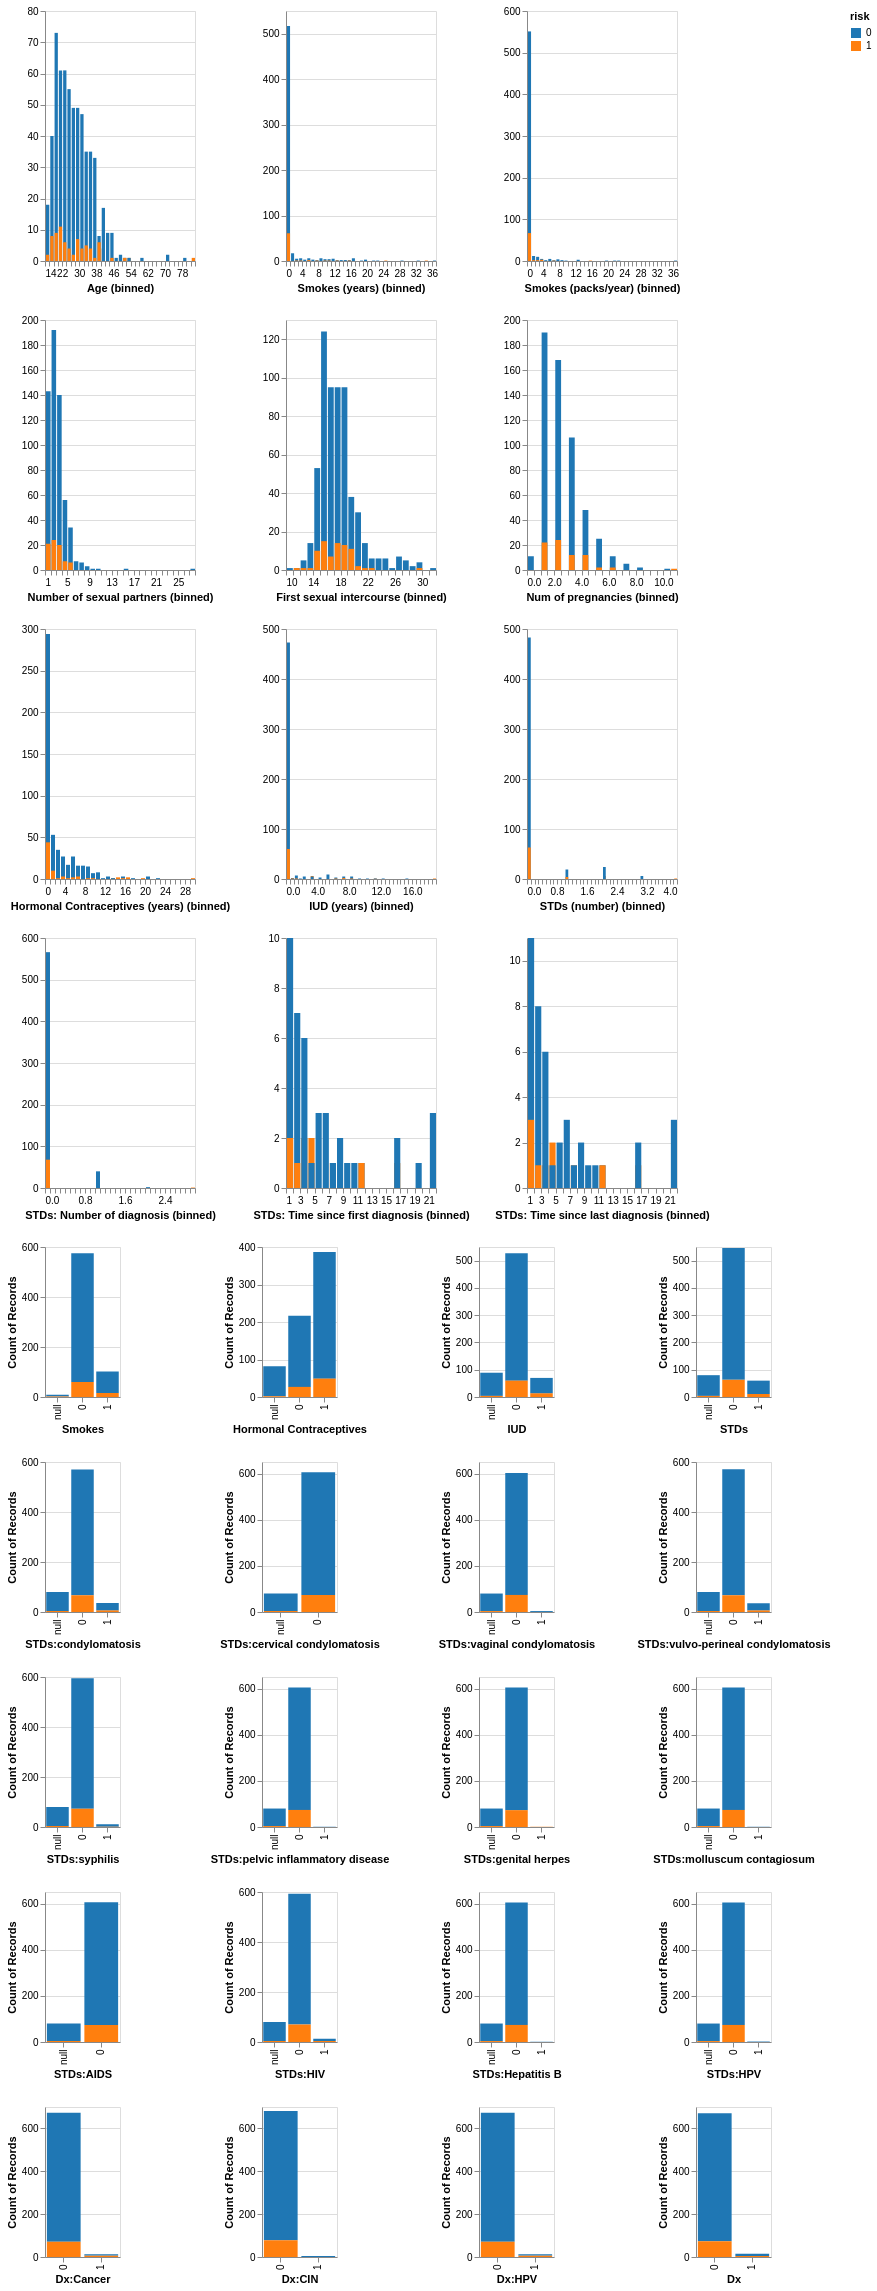

In [6]:
# create list of binary features
binary_features = ['Smokes', 'Hormonal Contraceptives', 'IUD', 'STDs', 'STDs:condylomatosis',
                   'STDs:cervical condylomatosis', 'STDs:vaginal condylomatosis',
                   'STDs:vulvo-perineal condylomatosis', 'STDs:syphilis', 'STDs:pelvic inflammatory disease',
                   'STDs:genital herpes', 'STDs:molluscum contagiosum', 'STDs:AIDS', 'STDs:HIV',
                   'STDs:Hepatitis B', 'STDs:HPV', 'Dx:Cancer', 'Dx:CIN', 'Dx:HPV', 'Dx']

# create list of numeric features
numeric_features = ['Age', 'Smokes (years)', 'Smokes (packs/year)', 'Number of sexual partners', 'First sexual intercourse',
                    'Num of pregnancies', 'Hormonal Contraceptives (years)', 'IUD (years)',
                    'STDs (number)', 'STDs: Number of diagnosis', 'STDs: Time since first diagnosis',
                    'STDs: Time since last diagnosis']

# create charts for binary features
binary_charts = alt.Chart(train_df).mark_bar().encode(
    alt.X(alt.repeat(), type='ordinal'),
    alt.Y('count()'),
    alt.Color('risk', type='ordinal')
).properties(
    height=150,
    width=75
).repeat(
    binary_features,
    columns=4
)

# create charts for numeric features
numeric_charts = alt.Chart(train_df).mark_bar().encode(
    alt.X(alt.repeat(), type='quantitative', bin=alt.Bin(maxbins=40)),
    alt.Y('count()', stack=False, title=''),
    alt.Color('risk', type='ordinal', scale=alt.Scale(scheme='category10'))
).properties(
    height=250,
    width=150
).repeat(
    numeric_features,
    columns=3
)

# display combined charts
numeric_charts & binary_charts

# References
---
Dua, Dheeru, and Casey Graff. 2017. “UCI Machine Learning Repository.” University of California, Irvine, School of Information; Computer Sciences. http://archive.ics.uci.edu/ml.

Fernandes, K., Cardoso, J.S., & Fernandes, J.C. (2017). Transfer Learning with Partial Observability Applied to Cervical Cancer Screening. Iberian Conference on Pattern Recognition and Image Analysis. https://www.semanticscholar.org/paper/Transfer-Learning-with-Partial-Observability-to-Fernandes-Cardoso/1c02438ba4dfa775399ba414508e9cd335b69012

Cervical cancer (Risk Factors) Data Set https://archive.ics.uci.edu/ml/datasets/Cervical+cancer+%28Risk+Factors%29